# Chainerチュートリアル

In [1]:
from __future__ import unicode_literals
import sys
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import chainer
from chainer import Variable, Function, Link
from chainer import Chain, optimizers
import chainer.functions as F
import chainer.links as L

%matplotlib inline
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (9, 6) # グラフの表示サイズを変更

In [2]:
sys.version_info

sys.version_info(major=2, minor=7, micro=13, releaselevel='final', serial=0)

In [3]:
chainer.__version__

'1.21.0'

## 基本オブジェクト

### Variables
- グラフの変数のノードに対応するオブジェクト
- 変数に入る実際のデータは配列

In [4]:
x1 = Variable(np.array([1]).astype(np.float32))
x2 = Variable(np.array([2]).astype(np.float32))
x3 = Variable(np.array([3]).astype(np.float32))

In [5]:
x1, x2, x3

(<variable at 0x11345dc50>,
 <variable at 0x11345dc90>)

In [6]:
x1.data, x2.data, x3.data # dataメソッドでデータにアクセスできる

(array([ 1.], dtype=float32),
 array([ 2.], dtype=float32),
 array([ 3.], dtype=float32))

In [7]:
z = (x1 - 2 * x2 - 1)**2 + (x2 * x3 - 1)**2 + 1
z

In [8]:
z.data

array([ 42.], dtype=float32)

この時点ではまだ $x$ の微分値は得られない

In [9]:
x1.grad #=> 何も返らない

$z$ は一度順方向の計算を行っているので、逆向きの計算を行うことで微分値が得られる

In [10]:
z.backward()

それぞれ以下の式に相当
$$
  \frac{\partial z}{\partial x_{1}}, \frac{\partial z}{\partial x_{2}}, \frac{\partial z}{\partial x_{3}}
$$

In [11]:
x1.grad, x2.grad, x3.grad 

(array([-8.], dtype=float32),
 array([ 46.], dtype=float32),
 array([ 20.], dtype=float32))

### Functions
- Variableを変数として持つ関数のパッケージ
- 三角関数などの他にも、活性化関数や損失関数なども用意されている

In [12]:
x = Variable(np.linspace(0, 2*np.pi, 20).astype(np.float32))
x.data

array([ 0.        ,  0.33069396,  0.66138792,  0.99208188,  1.32277584,
        1.6534698 ,  1.98416376,  2.31485772,  2.64555168,  2.97624564,
        3.3069396 ,  3.63763356,  3.96832752,  4.29902172,  4.62971544,
        4.96040964,  5.29110336,  5.62179756,  5.95249128,  6.28318548], dtype=float32)

In [13]:
F.sin(x).data

array([  0.00000000e+00,   3.24699461e-01,   6.14212692e-01,
         8.37166488e-01,   9.69400287e-01,   9.96584475e-01,
         9.15773332e-01,   7.35723913e-01,   4.75947410e-01,
         1.64594620e-01,  -1.64594561e-01,  -4.75947350e-01,
        -7.35723913e-01,  -9.15773392e-01,  -9.96584475e-01,
        -9.69400227e-01,  -8.37166488e-01,  -6.14212573e-01,
        -3.24699521e-01,   1.74845553e-07], dtype=float32)

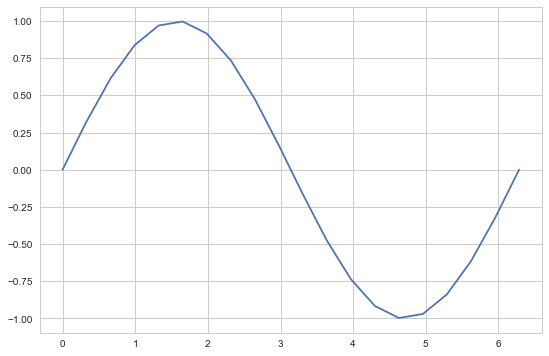

In [14]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(x.data, F.sin(x).data)

In [15]:
t = Variable(np.linspace(-10, 10, 20).astype(np.float32))
F.sigmoid(t).data

array([  4.53889370e-05,   1.30057335e-04,   3.72558832e-04,
         1.06671453e-03,   3.05026770e-03,   8.69011879e-03,
         2.45015919e-02,   6.71334863e-02,   1.70944601e-01,
         3.71376574e-01,   6.28623426e-01,   8.29055429e-01,
         9.32866514e-01,   9.75498438e-01,   9.91309881e-01,
         9.96949732e-01,   9.98933315e-01,   9.99627471e-01,
         9.99869943e-01,   9.99954581e-01], dtype=float32)

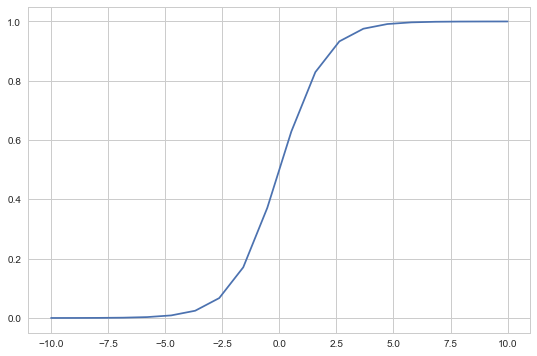

In [16]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(t.data, F.sigmoid(t).data)

微分もできる

In [17]:
x = Variable(np.array([np.pi]).astype(np.float32))
z = F.cos(x)
z.data

array([-1.], dtype=float32)

In [18]:
z.backward()

In [19]:
x.grad

array([  8.74227766e-08], dtype=float32)

In [20]:
(-1 * F.sin(x)).data  # 確認 cos(x)' = -sin(x)

array([  8.74227766e-08], dtype=float32)

変数が多次元の場合、関数の傾きの次元をあらかじめ教えておく必要がある

In [21]:
x = Variable(np.array([-np.pi, -np.pi/2, 0, np.pi/2, np.pi]).astype(np.float32))
z = F.sin(x)
z.data

array([  8.74227766e-08,  -1.00000000e+00,   0.00000000e+00,
         1.00000000e+00,  -8.74227766e-08], dtype=float32)

In [22]:
z.backward() # 傾きの次元を教えていないのでエラー

TypeError: ufunc 'multiply' output (typecode 'O') could not be coerced to provided output parameter (typecode 'f') according to the casting rule ''same_kind''

In [23]:
z.grad = np.ones(5).astype(np.float32) # 傾きの次元を教える

In [24]:
z.backward()

In [25]:
x.grad

array([ -1.00000000e+00,  -4.37113883e-08,   1.00000000e+00,
        -4.37113883e-08,  -1.00000000e+00], dtype=float32)

### Links
- Functionと同じく、Variableを変数として持つ関数
- Functionとの違いは、パラメータがあること
- Chanierが行えることは、ある意味このパラメータの推定とも言える

$l$ 層が3個、$l+1$ 層が4個ノードからなる全結合の関数は次のように定義

In [26]:
h = L.Linear(3, 4)

重荷のパラメータ $W$ には適当な初期値、バイアス $b$ には0が入っている

In [27]:
h.W.data, h.b.data

(array([[ 0.56956953, -0.48164156,  0.54706293],
        [-0.38974857, -0.37662694,  0.91205096],
        [ 0.01762401, -0.61431277, -0.45791286],
        [ 0.45931911, -0.5966149 , -0.22733608]], dtype=float32),
 array([ 0.,  0.,  0.,  0.], dtype=float32))

In [28]:
x = Variable(np.array(range(6)).astype(np.float32).reshape(2,3))
x.data

array([[ 0.,  1.,  2.],
       [ 3.,  4.,  5.]], dtype=float32)

In [29]:
y = h(x)
y.data

array([[ 0.61248434,  1.44747496, -1.53013849, -1.05128706],
       [ 2.51745701,  1.88450146, -4.6939435 , -2.14518261]], dtype=float32)

$W x + b$ を直接計算してみる。もちろん同じ結果になる

In [30]:
x.data.dot(h.W.data.T) + h.b.data

array([[ 0.61248434,  1.44747496, -1.53013849, -1.05128706],
       [ 2.51745701,  1.88450146, -4.6939435 , -2.14518261]], dtype=float32)

## Chainクラス
- Chainクラスを継承して独自のモデルを定義する
- `__init__`でネットワークの初期化、`__call__`で損失関数を実装する

In [31]:
class MyChain(Chain): # Chainクラスを継承
    def __init__(self): # ネットワーク初期化
        super(MyChain, self).__init__(
            l1 = L.Linear(4, 3),
            l2 = L.Linear(3, 3),
        )
        
    def __call__(self, x, y): # 損失関数
        fv = self.fwd(x, y) # Feed-Forward Prop
        loss = F.mean_squared_error(fv, y) # MSEで評価
        return loss
    
    def fwd(self, x, y):
        return F.sigmoid(self.l1(x))

パラメータの更新は`optimizers`モジュールを使うことで容易に行える

In [32]:
model = MyChain()
optimizer = optimizers.SGD() # 最適化アルゴリズムにSGDを選択
optimizer.setup(model)

In [ ]:
model.zerograds()   # 勾配の初期化
loss = model(x, y)  # 損失関数を評価し誤差を算出
loss.backward()     # 逆方向の計算、および勾配の計算
optimizer.update()  # パラメータを更新

## 以下落書き

In [34]:
F.softmax(Variable(np.asarray([-0.5, 0.5]).reshape(-1, 1))).data

array([[ 1.],
       [ 1.]])